# Image classificartion with EfficientNet😊
<br>Last updated on 30/08/2025 </br>
<br>Objective: We aim to classify images into 10 classes of custom animal dataset using EfficientNetV2s</br>
credit:<br>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html<br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html<br>
https://www.kaggle.com/datasets/alessiocorrado99/animals10<br>

In [15]:
! nvidia-smi

Tue Sep  9 04:51:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1.Download dataset

In [16]:
!wget https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip

--2025-09-09 04:51:32--  https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip [following]
--2025-09-09 04:51:32--  https://media.githubusercontent.com/media/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29663352 (28M) [application/zip]
Saving to: ‘Dataset_animal2.zip.1’

Dataset_animal2.zi

In [17]:
!unzip -q -o 'Dataset_animal2.zip'

## Library

In [18]:
!pip install pytorch-lightning
!pip install torchinfo

In [19]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import Accuracy

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device-> cuda:{device's number}

print(device)

cuda:0


# 2.Load and Normalize the dataset

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 32

In [23]:
class AnimalDataset(Dataset):

    def __init__(self,
                 img_dir,
                 transforms=None):

        super().__init__()
        self.label_image = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
        self.input_dataset = list()
        label_num = 0
        for label in self.label_image:
            _, _, files = next(os.walk(os.path.join(img_dir,label)))
            for image_name in files:
                input = [os.path.join(img_dir,label,image_name),label_num] # [image_path, label_num]
                self.input_dataset.append(input)
            label_num += 1

        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx):
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = AnimalDataset('./Dataset_animal2/train',transform_train)
valset = AnimalDataset('./Dataset_animal2/val',transform)
testset = AnimalDataset('./Dataset_animal2/test',transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

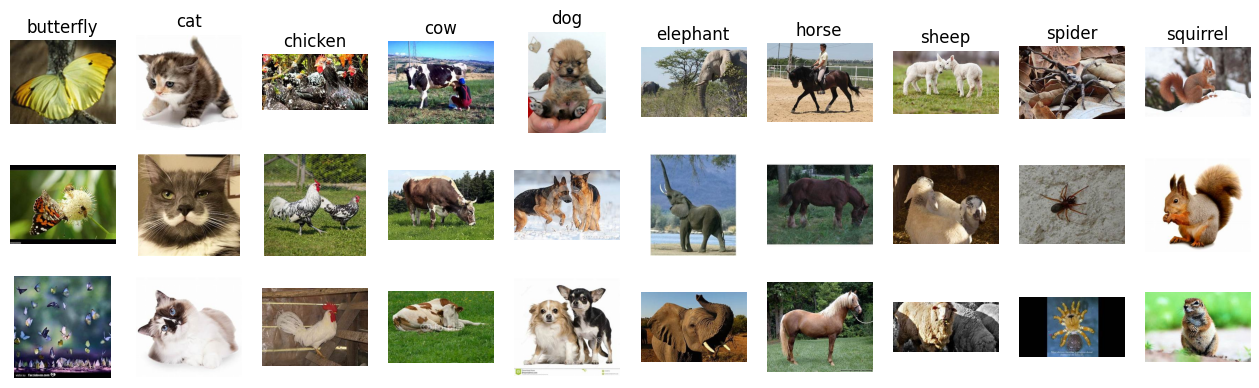

In [24]:
def PlotRandomFromEachClass(dataset,N,labels):
    Y = [label for image_path,label in dataset.input_dataset]
    C = np.unique(Y)
    M = len(C)
    plt.figure(figsize=(16, N*1.5))
    for i in range(M):
        mask = np.squeeze(Y == C[i])
        indexes = np.random.choice(len(dataset), N, replace=False, p=mask/sum(mask))
        for j in range(N):
            plt.subplot(N,M,j*M+i+1)
            img = Image.open(dataset.input_dataset[indexes[j]][0]).convert('RGB')
            plt.imshow(img, aspect="equal")
            plt.axis("off")
            if j == 0:
                plt.title(labels[i])

# img = Image.open(self.input_dataset[idx][0]).convert('RGB')

# classes = ('butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel')
PlotRandomFromEachClass(trainset, 3, labels=trainset.label_image)

In [25]:
trainset.__len__(), valset.__len__(), testset.__len__()

(1400, 300, 300)

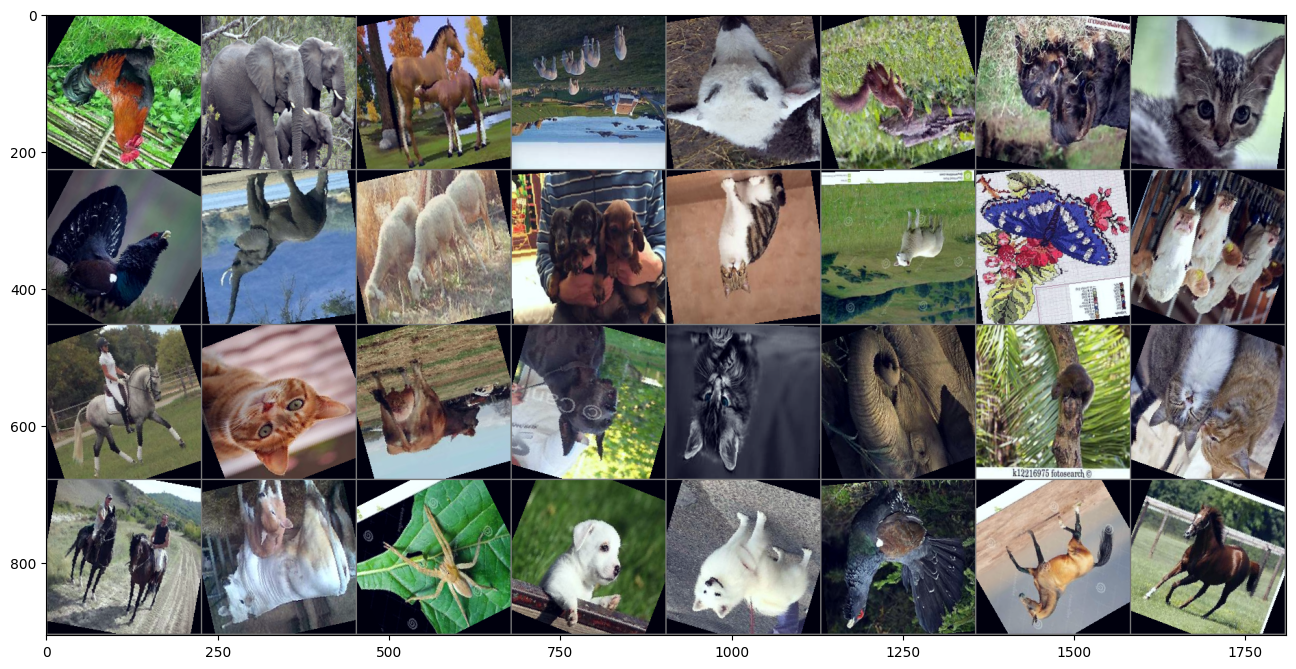

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    #Clipping input data to the valid range for imshow
    npimg = np.clip(npimg, 0, 1)
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 8
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [27]:
# print labels
for i in range(batch_size//nrow+1 if batch_size % nrow else batch_size//nrow):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

2   5   6   7   7   9   4   1  
2   5   7   4   1   7   0   3  
6   1   3   4   1   5   9   1  
6   3   8   4   4   2   6   6  


# 3.Define the Model and training configuration.

## Weights & Biases
- Weights & Biases (W&B, wandb) is a machine learning experiment tracking and visualization platform. Think of it as a more powerful, cloud-based alternative to TensorBoard.



In [28]:
from pytorch_lightning.loggers import WandbLogger
from transformers import EfficientNetForImageClassification

In [ ]:
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetb0 model from hugging face
        self.model = EfficientNetForImageClassification.from_pretrained(
        "google/efficientnet-b0",
        num_labels=num_classes,
        ignore_mismatched_sizes=True)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).logits
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.argmax(dim=1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

net = LitEfficientNetV2().to(device)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([10, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from torchinfo import summary as summary_info
print(summary_info(net, input_size = (32, 3, 224, 224))) # (batchsize,channel,width,height)

Layer (type:depth-idx)                                                 Output Shape              Param #
LitEfficientNetV2                                                      [32, 10]                  --
├─EfficientNetForImageClassification: 1-1                              [32, 10]                  --
│    └─EfficientNetModel: 2-1                                          [32, 1280]                --
│    │    └─EfficientNetEmbeddings: 3-1                                [32, 32, 112, 112]        928
│    │    └─EfficientNetEncoder: 3-2                                   [32, 1280, 7, 7]          4,006,620
│    │    └─AvgPool2d: 3-3                                             [32, 1280, 1, 1]          --
│    └─Dropout: 2-2                                                    [32, 1280]                --
│    └─Linear: 2-3                                                     [32, 10]                  12,810
Total params: 4,020,358
Trainable params: 4,020,358
Non-trainable params: 0
Total m

# 4.Training

In [45]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=1,            # Save only the best model
    filename="efficientnetv2-best-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

In [46]:
logger = WandbLogger(save_dir=".", name="lightning_logs", version=None)  # version auto-increments
trainer = pl.Trainer(logger=logger, max_epochs=5, callbacks=[checkpoint_callback])
trainer.fit(net, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                               | Params | Mode 
-------------------------------------------------------------------------
0 | model     | EfficientNetForImageClassification | 4.0 M  | train
1 | criterion | CrossEntropyLoss                   | 0      | train
2 | accuracy  | MulticlassAccuracy                 | 0      | train
-------------------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.081    Total estimated model params size (MB)
333       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 44: 'val_acc' reached 0.84667 (best 0.84667), saving model to './lightning_logs/f8ftc3hm/checkpoints/efficientnetv2-best-epoch=00-val_acc=0.8467.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 88: 'val_acc' reached 0.88000 (best 0.88000), saving model to './lightning_logs/f8ftc3hm/checkpoints/efficientnetv2-best-epoch=01-val_acc=0.8800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 132: 'val_acc' reached 0.89000 (best 0.89000), saving model to './lightning_logs/f8ftc3hm/checkpoints/efficientnetv2-best-epoch=02-val_acc=0.8900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 176: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 220: 'val_acc' reached 0.89667 (best 0.89667), saving model to './lightning_logs/f8ftc3hm/checkpoints/efficientnetv2-best-epoch=04-val_acc=0.8967.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Visualize Weights & Biases

In [47]:
print("W&B run page:", logger.experiment.url)

W&B run page: https://wandb.ai/apinyach-chulalongkorn-university/lightning_logs/runs/f8ftc3hm


# 5.Evaluation & Inference

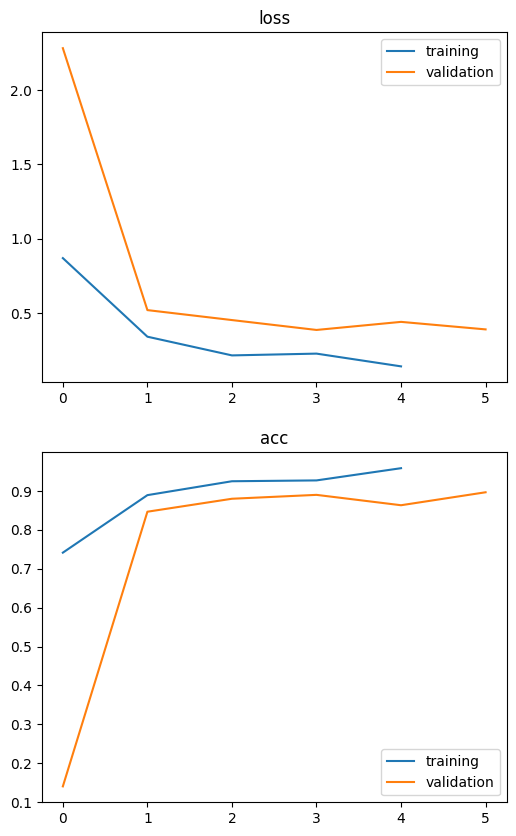

In [48]:
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([entry['train_loss'] for entry in net.train_metrics], label = 'training')
axs[0].plot([entry['val_loss'] for entry in net.val_metrics], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([entry['train_acc'] for entry in net.train_metrics], label = 'training')
axs[1].plot([entry['val_acc'] for entry in net.val_metrics], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

In [49]:
from typing import NewType
print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
best_model = LitEfficientNetV2.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
best_model.eval()
best_model.freeze()

Best model saved at: ./lightning_logs/f8ftc3hm/checkpoints/efficientnetv2-best-epoch=04-val_acc=0.8967.ckpt


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([10, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

criterion = nn.CrossEntropyLoss()
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )

    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

testing ...


  0%|          | 0/10 [00:00<?, ?it/s]

testing loss: 0.2983
              precision    recall  f1-score   support

           0     0.8529    0.9667    0.9062        30
           1     0.9286    0.8667    0.8966        30
           2     0.9032    0.9333    0.9180        30
           3     0.7941    0.9000    0.8438        30
           4     0.8125    0.8667    0.8387        30
           5     0.9630    0.8667    0.9123        30
           6     0.9032    0.9333    0.9180        30
           7     0.9583    0.7667    0.8519        30
           8     0.9000    0.9000    0.9000        30
           9     0.9655    0.9333    0.9492        30

    accuracy                         0.8933       300
   macro avg     0.8981    0.8933    0.8935       300
weighted avg     0.8981    0.8933    0.8935       300



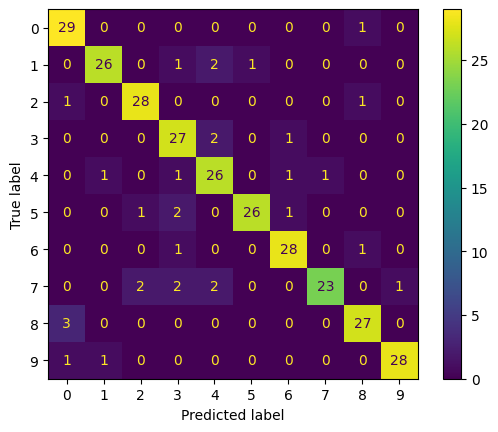

In [52]:
disp.plot()
plt.show()

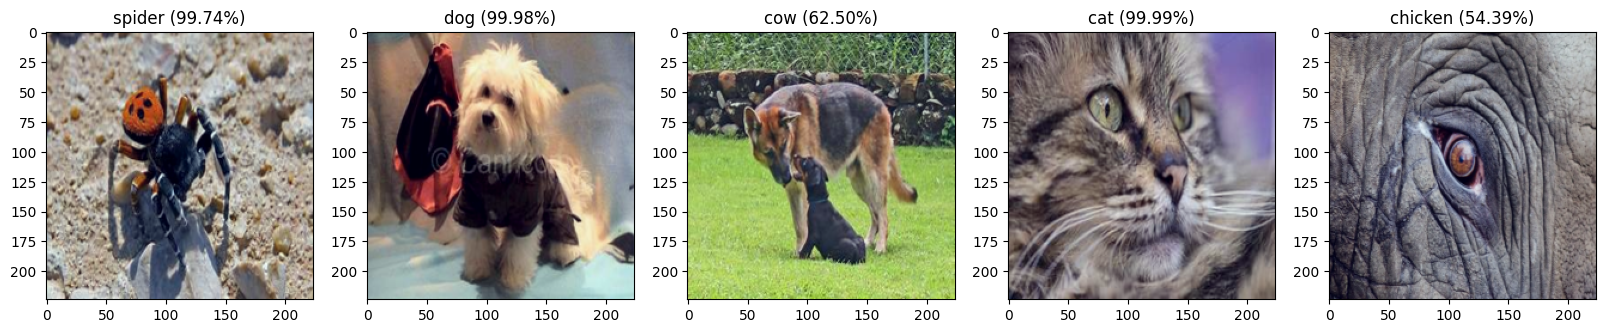

In [54]:
plt.figure(figsize=(20,5))
dataiter = iter(testloader)
inputs, labels = next(dataiter)
with torch.no_grad():

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels = list(labels.cpu().numpy())
        y_predict = list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())

# We selected a sample from the first five images for visualization
for i in range(5):
    plt.subplot(1,5,i+1)
    img = inputs[i]
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    most_prob = np.argmax(y_probs[i])
    label = testset.label_image[most_prob]
    prob = y_probs[i][most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")